
# Whisper Disfluency Evaluation

Dieses Notebook analysiert die in `.env` hinterlegte *KASHAF_DISFLUENCIES*-Ablage. Dort liegen zwei Excel-Workbooks mit bereits vorhandenen Ground-Truth-Transkripten sowie Whisper-Ausgaben:

- `Whisper_lora_KSoF_5_fold_only_uf_base_transcripts.xlsx`
- `Whisper_lora_KSoF_5_fold_only_uf_finetuned_transcripts.xlsx`

Jedes Workbook umfasst fünf Folds (Sheets), einmal mit einem reinen Whisper Large V3 Turbo Modell und einmal mit einem auf Dysfluencies feinabgestimmten Pendant. Ziel ist es, störende Special Tokens aus den Hypothesen zu entfernen, anschließend die Word Error Rate (WER) pro Fold zu berechnen und beide Varianten miteinander zu vergleichen.



## 1. Setup

Lädt Standardbibliotheken, resolved Pfade aus der `.env` und prüft die Verfügbarkeit der Workbooks.

> ⚠️ **Voraussetzungen**: `pandas`, `openpyxl` (für das Lesen der XLSX-Dateien) sowie `jiwer` müssen installiert sein. Wir arbeiten ausschließlich offline auf vorhandenen Excel-Dateien.


In [15]:

from dotenv import load_dotenv
from jiwer import wer
import pandas as pd
from pathlib import Path
from typing import Dict, Iterable, List
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import os

load_dotenv()

sns.set_theme(style="whitegrid")

DATA_ROOT = os.getenv("KASHAF_DISFLUENCIES")
if not DATA_ROOT:
    raise EnvironmentError(
        "Umfeldvariable KASHAF_DISFLUENCIES ist nicht gesetzt. Ergänze sie in der `.env` Datei."
    )

DATA_ROOT = Path(DATA_ROOT)
BASE_WORKBOOK = DATA_ROOT / "Whisper_lora_KSoF_5_fold_only_uf_base_transcripts.xlsx"
FINETUNED_WORKBOOK = DATA_ROOT / "Whisper_lora_KSoF_5_fold_only_uf_finetuned_transcripts.xlsx"

for workbook in (BASE_WORKBOOK, FINETUNED_WORKBOOK):
    if not workbook.is_file():
        raise FileNotFoundError(f"Workbook fehlt: {workbook}")

BASE_WORKBOOK, FINETUNED_WORKBOOK


(PosixPath('/Volumes/T7 Touch/datasets/kashaf_disfluencies/Whisper_lora_KSoF_5_fold_only_uf_base_transcripts.xlsx'),
 PosixPath('/Volumes/T7 Touch/datasets/kashaf_disfluencies/Whisper_lora_KSoF_5_fold_only_uf_finetuned_transcripts.xlsx'))


## 2. Hilfsfunktionen

- **Spreadsheet-Lader**: ignoriert das leere Default-Sheet, liest `Fold_*`-Sheets ein und reduziert sie auf Referenz- und Whisper-Spalten.
- **Token-Bereinigung**: entfernt Whisper-spezifische Sondertokens und Zeitmarken.
- **WER-Helfer**: berechnet die WER pro Fold und aggregiert über das gesamte Workbook.


In [16]:
import re

FOLD_PREFIX = "fold"
REFERENCE_CANDIDATES = {
    "Reference Transcript",
    "reference transcript",
    "reference",
    "Reference",
}
HYPOTHESIS_CANDIDATES = {
    "Whisper Transcript",
    "whisper transcript",
    "prediction",
    "hypothesis",
}

SPECIAL_TOKEN_PATTERN = re.compile(r"<\|[^|]+\|>")
TIMESTAMP_PATTERN = re.compile(r"\[(?:\d{1,2}:)?\d{1,2}:\d{2}\.\d{2}\]")
MULTISPACE_PATTERN = re.compile(r"\s+")


def load_fold_frames(path: Path) -> Dict[str, pd.DataFrame]:
    xls = pd.ExcelFile(path)
    frames: Dict[str, pd.DataFrame] = {}

    for sheet in xls.sheet_names:
        if not sheet.lower().startswith(FOLD_PREFIX):
            continue
        frame = pd.read_excel(xls, sheet_name=sheet)
        if frame.empty:
            continue
        frame = frame.rename(columns=lambda c: str(c).strip())

        ref_column = None
        hyp_column = None
        for column in frame.columns:
            if column in REFERENCE_CANDIDATES:
                ref_column = column
            if column in HYPOTHESIS_CANDIDATES:
                hyp_column = column
        if ref_column is None or hyp_column is None:
            raise KeyError(
                f"Erwarte Spalten für Referenz & Whisper-Transcript in Sheet '{sheet}'. Gefunden: {frame.columns.tolist()}"
            )

        subset = frame[[ref_column, hyp_column]].rename(columns={ref_column: "reference", hyp_column: "hypothesis"})
        subset = subset.dropna(subset=["reference", "hypothesis"])
        if subset.empty:
            continue
        frames[sheet] = subset

    if not frames:
        raise ValueError(f"Keine Fold-Sheets in {path} gefunden.")

    return frames


def clean_transcript(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.strip()
    text = SPECIAL_TOKEN_PATTERN.sub(" ", text)
    text = TIMESTAMP_PATTERN.sub(" ", text)
    text = text.replace("▁", " ")
    text = text.replace("|", " ")
    text = MULTISPACE_PATTERN.sub(" ", text)
    return text.strip().lower()


def compute_wer_for_pairs(references: Iterable[str], hypotheses: Iterable[str]) -> float:
    refs = [clean_transcript(r) for r in references]
    hyps = [clean_transcript(h) for h in hypotheses]
    ref_text = "\n".join(refs)
    hyp_text = "\n".join(hyps)
    return wer(ref_text, hyp_text)


@dataclass
class FoldResult:
    workbook_label: str
    fold_name: str
    wer: float
    utterances: int


@dataclass
class WorkbookSummary:
    label: str
    fold_results: List[FoldResult]
    overall_wer: float
    total_utterances: int


def evaluate_workbook(label: str, workbook_path: Path) -> WorkbookSummary:
    frames = load_fold_frames(workbook_path)
    fold_results: List[FoldResult] = []
    all_refs: List[str] = []
    all_hyps: List[str] = []

    for fold_name, frame in sorted(frames.items()):
        refs = frame["reference"].tolist()
        hyps = frame["hypothesis"].tolist()

        fold_wer = compute_wer_for_pairs(refs, hyps)
        fold_results.append(
            FoldResult(
                workbook_label=label,
                fold_name=fold_name,
                wer=fold_wer,
                utterances=len(refs),
            )
        )
        all_refs.extend(refs)
        all_hyps.extend(hyps)

    overall = compute_wer_for_pairs(all_refs, all_hyps)
    return WorkbookSummary(
        label=label,
        fold_results=fold_results,
        overall_wer=overall,
        total_utterances=len(all_refs),
    )



## 3. WER-Berechnung

Wir evaluieren Basis- und Finetuning-Workbooks, führen die Kennzahlen pro Fold zusammen und ergänzen den aggregierten Gesamtwert.


In [17]:

base_summary = evaluate_workbook("baseline", BASE_WORKBOOK)
finetuned_summary = evaluate_workbook("finetuned", FINETUNED_WORKBOOK)

summary_rows = []
for summary in (base_summary, finetuned_summary):
    for fold_result in summary.fold_results:
        summary_rows.append(
            {
                "model_variant": summary.label,
                "fold": fold_result.fold_name,
                "wer": fold_result.wer,
                "utterances": fold_result.utterances,
            }
        )
    summary_rows.append(
        {
            "model_variant": summary.label,
            "fold": "overall",
            "wer": summary.overall_wer,
            "utterances": summary.total_utterances,
        }
    )

wer_summary_df = pd.DataFrame(summary_rows)
wer_summary_df


,model_variant,fold,wer,utterances
0,baseline,Fold_1,0.399524,357
1,baseline,Fold_2,0.410967,305
2,baseline,Fold_3,0.373710,213
3,baseline,Fold_4,0.401840,238
4,baseline,Fold_5,0.424867,333
5,baseline,overall,0.403996,1446
6,finetuned,Fold_1,0.261667,357
7,finetuned,Fold_2,0.258780,305
8,finetuned,Fold_3,0.200987,213
9,finetuned,Fold_4,0.240089,238



## 4. Visualisierung

Zum schnellen Vergleich der beiden Modellvarianten wird der `overall`-WER in einem Balkendiagramm dargestellt. Zusätzlich zeigen wir die Einzelwerte pro Fold.


/var/folders/6l/kwcycbvx6hv5sw6sz8qf8xk00000gn/T/ipykernel_76394/624221765.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=overall_df, x="model_variant", y="wer", palette="muted")


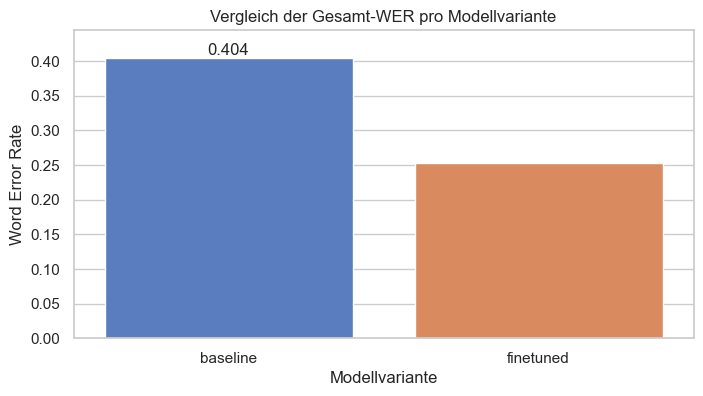

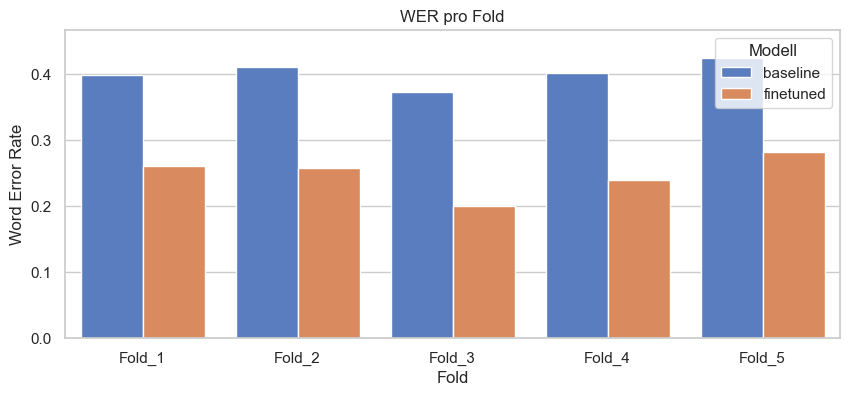

In [18]:

overall_df = wer_summary_df[wer_summary_df["fold"] == "overall"].copy()
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=overall_df, x="model_variant", y="wer", palette="muted")
ax.bar_label(ax.containers[0], fmt="{:.3f}")
plt.ylim(0, max(0.2, overall_df["wer"].max() * 1.1))
plt.title("Vergleich der Gesamt-WER pro Modellvariante")
plt.ylabel("Word Error Rate")
plt.xlabel("Modellvariante")
plt.show()

plt.figure(figsize=(10, 4))
fold_df = wer_summary_df[wer_summary_df["fold"] != "overall"].copy()
ax = sns.barplot(data=fold_df, x="fold", y="wer", hue="model_variant", palette="muted")
plt.title("WER pro Fold")
plt.ylabel("Word Error Rate")
plt.xlabel("Fold")
plt.ylim(0, max(0.2, fold_df["wer"].max() * 1.1))
plt.legend(title="Modell")
plt.show()


In [19]:
latex_df = overall_df[["model_variant", "wer"]].copy()
latex_df = latex_df.rename(columns={"model_variant": "Model Variant", "wer": "WER"})
latex_df["WER"] = latex_df["WER"].map(lambda value: round(value, 4))
latex_table = latex_df.to_latex(index=False, float_format="{:.4f}".format, caption="Comparison of overall WER per Whisper Large V3 Turbo model variant on dysfluencies", label="tab:overall_wer")
print(latex_table)


\begin{table}
\caption{Comparison of overall WER per model variant on dysfluencies}
\label{tab:overall_wer}
\begin{tabular}{lr}
\toprule
Model Variant & WER \\
\midrule
baseline & 0.4040 \\
finetuned & 0.2528 \\
\bottomrule
\end{tabular}
\end{table}




## 5. Interpretation & nächste Schritte

- Prüfe signifikante Differenzen zwischen Basismodell und Finetuning. Eine niedrigere WER deutet auf bessere Performance hin.
- Für qualitative Analysen lassen sich die schwierigsten Beispiele je Fold identifizieren (z. B. durch Sortierung nach Fehlerdifferenz).
- Falls weitere Spezial-Tokens auftreten, erweitere die Funktion `clean_transcript` entsprechend.
